In [28]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)


True

In [16]:
# Bucket details
import boto3
BUCKET_NAME = "pacp-langflow-bucket"
PREFIX = "my_pdfs/"
LOCAL_FOLDER = "./"

# Ensure the local folder exists
os.makedirs(LOCAL_FOLDER, exist_ok=True)

# Initialize S3 client (credentials are automatically picked up from environment variables)
s3_client = boto3.client("s3")


# List and download PDF files from the S3 bucket
def download_pdfs_from_s3():
    try:
        response = s3_client.list_objects_v2(Bucket=BUCKET_NAME, Prefix=PREFIX)
        if "Contents" in response:
            for obj in response["Contents"]:
                file_key = obj["Key"]
                if file_key.endswith(".pdf"):  # Only process PDF files
                    local_file_path = os.path.join(
                        LOCAL_FOLDER, os.path.basename(file_key)
                    )
                    s3_client.download_file(BUCKET_NAME, file_key, local_file_path)
                    print(f"✅ Downloaded: {file_key} to {local_file_path}")
        else:
            print("No files found in the specified prefix.")
    except Exception as e:
        print(f"Error: {e}")




In [5]:
download_pdfs_from_s3()

✅ Downloaded: my_pdfs/ada_lovelace.pdf to ./ada_lovelace.pdf
✅ Downloaded: my_pdfs/alan_turing.pdf to ./alan_turing.pdf
✅ Downloaded: my_pdfs/albert_einstein.pdf to ./albert_einstein.pdf
✅ Downloaded: my_pdfs/alexander_graham_bell.pdf to ./alexander_graham_bell.pdf
✅ Downloaded: my_pdfs/alexander_the_great.pdf to ./alexander_the_great.pdf
✅ Downloaded: my_pdfs/alfred_russel_wallace.pdf to ./alfred_russel_wallace.pdf
✅ Downloaded: my_pdfs/aristotle.pdf to ./aristotle.pdf
✅ Downloaded: my_pdfs/charles_babbage.pdf to ./charles_babbage.pdf
✅ Downloaded: my_pdfs/charles_darwin.pdf to ./charles_darwin.pdf
✅ Downloaded: my_pdfs/galileo_galilei.pdf to ./galileo_galilei.pdf
✅ Downloaded: my_pdfs/index.pdf to ./index.pdf
✅ Downloaded: my_pdfs/isaac_newton.pdf to ./isaac_newton.pdf
✅ Downloaded: my_pdfs/leonardo_da_vinci.pdf to ./leonardo_da_vinci.pdf
✅ Downloaded: my_pdfs/marie_curie.pdf to ./marie_curie.pdf
✅ Downloaded: my_pdfs/michelangelo.pdf to ./michelangelo.pdf
✅ Downloaded: my_pdfs/nicol

Now let's transform the PDF files into Langchain documents. This is a bit silly, but there are more sophisticated ways to do it. Two things to keep in mind are that Langchain Documents are in-memory objects, and it is the glue that holds the different Langchain classes together.

In [17]:
import os
from langchain_community.document_loaders import PyPDFLoader

pdf_dir = "/home/roberto/sourceCode/pedropacheco_graphrag/graphrag"
pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]

pages = []
for file in pdf_files:
    path = os.path.join(pdf_dir, file)
    loader = PyPDFLoader(path)
    async for page in loader.alazy_load():
        pages.append(page)

print(f"✅ Loaded {len(pages)} pages from {len(pdf_files)} PDF files")

✅ Loaded 20 pages from 20 PDF files


Let's examine one of the documents. Note the type of the object. It isn't a Python JSON object but a Langhain Document.


In [18]:
import json

def print_document(document):
    print(f"Document type: {type(document)}")
    
    print("Content:")
    print(document.page_content)  # Print the text content

    print("\nMetadata:")
    print(json.dumps(document.metadata, indent=4))  # Pretty-print the metadata dictionary
print_document(pages[0])


Document type: <class 'langchain_core.documents.base.Document'>
Content:
Alexander the Great
Alexander III of Macedon, commonly known as Alexander the Great, was a king of the ancient Greek kingdom of Macedon and a member of the Argead dynasty. He was born in Pella in 356 BC and succeeded his father Philip II to the throne at the age of 20. He spent most of his ruling years on
an unprecedented military campaign through Asia and northeast Africa, and by the age of 30, he had created one of the largest empires of the ancient world, stretching from Greece to northwestern India.
Alexander was undefeated in battle and is widely considered one of history's most successful military commanders. His campaigns greatly increased the cultural interactions and exchanges between the East and West, leading to the Hellenistic period.
Alexander was born on 20 July 356 BC in Pella, Macedon. He died on 10/11 June 323 BC in the Palace of Nebuchadnezzar II, Babylon, Mesopotamia (modern-day Iraq).
Related f

Pay particular attention to the metadata section. Note that pypdf was kind enough to generate some level of metadata, but it is purely structural, not semantic. In the next step, we will use a Datastax GraphRAG "transformer" to extract labels based on keywords. Because I am a history buff, I used middle school level "who was" https://www.whowasbookseries.com/who-was/ books and will perform name entity recognition using the KeyBERT model. While the underlying technology is relatively sophisticated, our implementation makes it easy to use.


In [19]:
from gliner import GLiNER
from langchain_graph_retriever.transformers.gliner import GLiNERTransformer

gliner = GLiNERTransformer(labels=["associates", "places", "dates", "events"])

gliner_documents = gliner.transform_documents(documents=pages)
print_document(gliner_documents[0])


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 30795.18it/s]
/home/roberto/sourceCode/pedropacheco_graphrag/graphrag/.venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Document type: <class 'langchain_core.documents.base.Document'>
Content:
Alexander the Great
Alexander III of Macedon, commonly known as Alexander the Great, was a king of the ancient Greek kingdom of Macedon and a member of the Argead dynasty. He was born in Pella in 356 BC and succeeded his father Philip II to the throne at the age of 20. He spent most of his ruling years on
an unprecedented military campaign through Asia and northeast Africa, and by the age of 30, he had created one of the largest empires of the ancient world, stretching from Greece to northwestern India.
Alexander was undefeated in battle and is widely considered one of history's most successful military commanders. His campaigns greatly increased the cultural interactions and exchanges between the East and West, leading to the Hellenistic period.
Alexander was born on 20 July 356 BC in Pella, Macedon. He died on 10/11 June 323 BC in the Palace of Nebuchadnezzar II, Babylon, Mesopotamia (modern-day Iraq).
Related f

NER isn't an exact science, and results will vary. Datastax Graph RAG offers a few alternatives, but feel free to use other models or methodologies. IMHO, metadata extraction is the key to your graph rag success. Let's look at alternatives.

In [20]:
from keybert import KeyBERT
import copy
# Initialize KeyBERT model
kw_model = KeyBERT()
keybert_documents = copy.deepcopy(pages)
for doc in keybert_documents:
    # Extract keywords from the page_content
    keywords = kw_model.extract_keywords(
        doc.page_content, keyphrase_ngram_range=(1, 2), stop_words="english"
    )

    # Add the filtered keywords to the metadata
    doc.metadata["keywords"] = keywords

print_document(keybert_documents[0])


Document type: <class 'langchain_core.documents.base.Document'>
Content:
Alexander the Great
Alexander III of Macedon, commonly known as Alexander the Great, was a king of the ancient Greek kingdom of Macedon and a member of the Argead dynasty. He was born in Pella in 356 BC and succeeded his father Philip II to the throne at the age of 20. He spent most of his ruling years on
an unprecedented military campaign through Asia and northeast Africa, and by the age of 30, he had created one of the largest empires of the ancient world, stretching from Greece to northwestern India.
Alexander was undefeated in battle and is widely considered one of history's most successful military commanders. His campaigns greatly increased the cultural interactions and exchanges between the East and West, leading to the Hellenistic period.
Alexander was born on 20 July 356 BC in Pella, Macedon. He died on 10/11 June 323 BC in the Palace of Nebuchadnezzar II, Babylon, Mesopotamia (modern-day Iraq).
Related f

And if you are inclined, you can always use an LLM to extract keywords from the document.

Remember that this is quite an expensive operation.

In [21]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.documents import Document
import copy

# Initialize the OpenAI chat model
llm = ChatOpenAI(model="gpt-4", temperature=0)

# Define the prompt template
prompt_template = """
Extract named entities from the following text.
Categorize them into predefined types such as PEOPLE, PLACES, DATES, EVENTS.
Provide the entities and their corresponding types as a structured JSON response.

If there is more than one value for the same entity type, create an array of entity names.

[START OF TEXT]
{text}
[END OF TEXT]

The response format should be a json, where the key is the category, and the value is what you extracted. 
"""

prompt = PromptTemplate(input_variables=["text"], template=prompt_template)

# Create an LLM chain
chain = LLMChain(llm=llm, prompt=prompt)

def extract_named_entities(documents):
    
    for document in documents:
        response = chain.run({"text": document.page_content})
        
        # Parse the response string into a JSON object
        try:
            entities = json.loads(response)  # Convert the string to a JSON object
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for document {document.id}: {e}")
            entities = {}  
        yield entities

# Extract named entities
llm_ner_documents = copy.deepcopy(pages)

for document, entities in zip(llm_ner_documents, extract_named_entities(llm_ner_documents)):
    document.metadata.update(entities)


print_document(llm_ner_documents[18])


Document type: <class 'langchain_core.documents.base.Document'>
Content:
Alan Turing
Alan Turing was an English mathematician, computer scientist, logician, cryptanalyst, philosopher, and theoretical biologist. Turing was highly influential in the development of theoretical computer science, providing a formalisation of the concepts of algorithm and computation with the Turing
machine, which can be considered a model of a general-purpose computer.
Turing is widely considered to be the father of theoretical computer science and artificial intelligence. During World War II, Turing played a crucial role in cracking intercepted coded messages that enabled the Allies to defeat the Nazis in many crucial engagements.
Alan Turing was born on 23 June 1912 in Maida Vale, London, England. He died on 7 June 1954 in Wilmslow, Cheshire, England.
Related figures: Charles Babbage, Ada Lovelace

Metadata:
{
    "producer": "Skia/PDF m131",
    "creator": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537

The best possible result comes from using the LLM. Both liner and keybert are smaller local models, so it is understandable why the LLM gives a more complete extraction. However, it is slower and more expensive.

Now, let's finally save one of the document sets into the Vector Store. I will go with the documents enriched by the LLM. We also need an embedding to take advantage of the Langchain fromDocument method.



In [22]:
from langchain_openai import OpenAIEmbeddings
import os

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
# Test text for embedding
test_text = "This is a test sentence."

# Generate the embedding
embedding_vector = embedding_model.embed_query(test_text)

# Measure the length of the vector
vector_length = len(embedding_vector)

# Output results
print(f"Generated Embedding Vector Length: {vector_length}")


Generated Embedding Vector Length: 1536


Be careful. This cell truncates the collection

In [29]:
from langchain_astradb import AstraDBVectorStore

vectorstore = AstraDBVectorStore(
    collection_name=os.getenv("ASTRA_DB_COLLECTION"),
    namespace=os.getenv("ASTRA_DB_KEYSPACE"),
    embedding=embedding_model,
)
#vectorstore.astra_env.collection.delete_all()


In [30]:
vectorstore.add_documents(llm_ner_documents)

['4c79c174c2124b4cb9f0762807c1752f',
 'b8ab349893a04f0aab4596139756bcc8',
 '787e00209e314d7ba9b73ab6be4c3fcc',
 '82c812ed71d9490aa3b345c5f47c1b82',
 'ed8ae5eb98c940049f326cf6d43fd386',
 '8a3a65a1bdba40ea90f365e2d468d2d1',
 '08de99b1620647cfbdf5923082198d35',
 'dcdc742a50ae488bae40d60a1463d072',
 '81c7274234544a9db7e3358803d41ca4',
 '7c66068c5ef248e88e603c3bb2c67e3e',
 'c2027fdd252a4abda5d569ad8dfbac31',
 'b586f42edb214f79ae5540753be9c5e5',
 'e0c7cd93f9584948b55a40cd5d41311e',
 '2f250a44f6bf4848a82c2355d374cd58',
 '985b610552af45dea473d4559acd6d34',
 '4b8ca539bd7742e6830dbc139b859034',
 '9f0ac823e75f49b8a39dfb770dc88fe3',
 'cb1c0ed4135a4bc1ac7cf7af0e295909',
 '89cd7da3a3d841a48e6062d89342dc4b',
 '8044ff6bfc0e427aac77b01e31211865']

The data has been saved to AstraDB. Now let's do the traditional vector search.

In [31]:
import pprint

query_text = "Information about Plato"
results = vectorstore.similarity_search(query_text, k=3)
for plato in results:
    print(plato.page_content)
    pprint.pprint(plato.metadata)
    print("-------------------")


Plato
Plato was a philosopher in Classical Greece and the founder of the Academy in Athens, the first institution of higher learning in the Western world. He is widely considered one of the most important figures in the development of Western philosophy.
Plato's writings explored justice, beauty, and equality, and also contained discussions in aesthetics, political philosophy, theology, cosmology, epistemology, and the philosophy of language. His most famous works include "The Republic," "The Symposium," and "The Allegory of the Cave."
Plato was born in 428/427 or 424/423 BC in Athens, Greece. He died in 348/347 BC in Athens, Greece.
Related figures: Aristotle, Socrates
{'DATES': ['428/427 or 424/423 BC', '348/347 BC'],
 'EVENTS': ['The Republic', 'The Symposium', 'The Allegory of the Cave'],
 'PEOPLE': ['Plato', 'Aristotle', 'Socrates'],
 'PLACES': ['Classical Greece',
            'Academy in Athens',
            'Western world',
            'Athens, Greece'],
 'creationdate': '2025-0

Now, let's set up a simple graph retriever using the PLACES metadata item, an edge equality rule, and a traverse.


In [32]:
from graph_retriever.strategies import Eager
from langchain_graph_retriever import GraphRetriever

# All siblings of the query node.
# k=10 total result set size
# start_k=1 closest document from vector search
# depth=2 depth of the graph to search
simple = GraphRetriever(
    store=vectorstore,
    edges=[("PLACES", "PLACES")],
    strategy=Eager(k=10, start_k=3, max_depth=2),
)

results = simple.invoke("Information about Plato")

for doc in results:
    places = doc.metadata.get("PLACES")
    pprint.pprint(f"{doc.page_content} \n {places}")
    print("-------------------")


('Plato\n'
 'Plato was a philosopher in Classical Greece and the founder of the Academy '
 'in Athens, the first institution of higher learning in the Western world. He '
 'is widely considered one of the most important figures in the development of '
 'Western philosophy.\n'
 "Plato's writings explored justice, beauty, and equality, and also contained "
 'discussions in aesthetics, political philosophy, theology, cosmology, '
 'epistemology, and the philosophy of language. His most famous works include '
 '"The Republic," "The Symposium," and "The Allegory of the Cave."\n'
 'Plato was born in 428/427 or 424/423 BC in Athens, Greece. He died in '
 '348/347 BC in Athens, Greece.\n'
 'Related figures: Aristotle, Socrates \n'
 " ['Classical Greece', 'Academy in Athens', 'Western world', 'Athens, "
 "Greece']")
-------------------
('Aristotle\n'
 'Aristotle was a Greek philosopher and polymath during the Classical period '
 'in Ancient Greece. Taught by Plato, he was the founder of the Lyc

Now let's use the same data we already have, using the PEOPLE metadata item and an edge equality rule, and traverse

In [33]:
# All siblings of the query node.
# k=10 total result set size
# start_k=1 closest document from vector search
# depth=2 depth of the graph to search
by_people = GraphRetriever(
    store=vectorstore,
    edges=[("PEOPLE", "PEOPLE")],
    strategy=Eager(k=10, start_k=3, max_depth=2),
)

results = by_people.invoke("Information about Greece")

for doc in results:
    people = (
        doc.metadata.get("PEOPLE")
    )
    pprint.pprint(f"{doc.page_content} \n {people}")


('Aristotle\n'
 'Aristotle was a Greek philosopher and polymath during the Classical period '
 'in Ancient Greece. Taught by Plato, he was the founder of the Lyceum, the '
 'Peripatetic school of philosophy, and the Aristotelian tradition. His '
 'writings cover many subjects including physics, biology, zoology,\n'
 'metaphysics, logic, ethics, aesthetics, poetry, theatre, music, rhetoric, '
 'psychology, linguistics, economics, politics, and government.\n'
 'Aristotle provided a complex synthesis of the various philosophies existing '
 'prior to him. It was above all from his teachings that the West inherited '
 'its intellectual lexicon, as well as problems and methods of inquiry. As a '
 'result, his philosophy has exerted a unique influence on almost every form\n'
 'of knowledge in the West and it continues to be a subject of contemporary '
 'philosophical discussion.\n'
 'Aristotle was born in 384 BC in Stagira, Chalcidice, Greece. He died in 322 '
 'BC in Euboea, Greece.\n'
 'Rel

## People always want to see a graph!

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
from langchain_graph_retriever.document_graph import create_graph


def plot_document_graph(documents, edges):
    document_graph = create_graph(
        documents=documents,
        edges=edges,
    )

    nx.draw(document_graph, with_labels=True)
    plt.show()

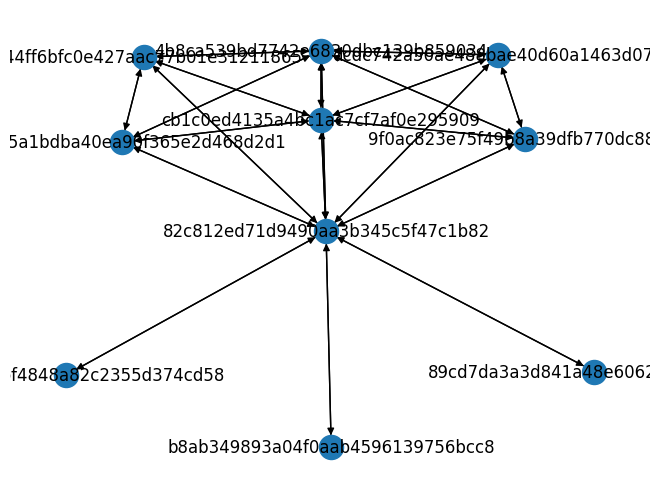

In [36]:
results = by_people.invoke("Information about Einstein")
plot_document_graph(results, by_people.edges)